# Seismic Modelling with Devito

In order to create a numerical model of a seismic survey, we need to solve the wave equation and implement source and receiver interpolation to inject the source and record the seismic wave at sparse point locations in a discretized grid.

## Define the physical problem

The first step is to define the physical model:

- What are the physical dimension of interest
- What is the velocity profile of this physical domain

We will create a simple velocity model here by hand for demonstration purposes. This model essentially consists of two layers, each with a different velocity: $1.5km/s$ in the top layer and $2.5km/s$ in the bottom layer.

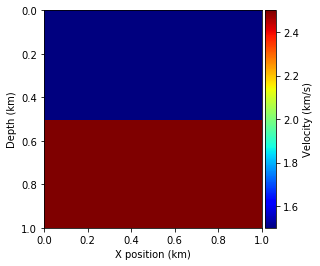

In [2]:
import numpy as np
from examples.seismic import Model, plot_velocity

# Define a physical size
shape = (101, 101)    # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)     # What is the location of the top left corner. 
                      # This is necessary to define the absolute location of the source and receivers

# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:, :51] = 1.5
v[:, 51:] = 2.5

# With the velocity and model size defined, we can create the seismic model that
# encapsulate this properties. We also define the size of the absorbing layer as 10 grid points
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbpml=10)

plot_velocity(model)

## Set acquisition geometry

To fully define our problem setup we also need to define the source that injects the wave to model and the set of receiver locations at which to sample the wavefield. The source time signature will be modelled using a Ricker wavelet defined as


\begin{equation}
q(t) =  (1-2\pi^2f_0^2(t-\frac{1}{f_0})^2)e^{-\pi^2f_0^2(t-\frac{1}{f_0})}
\end{equation}

To fully define the source signature we first need to define the time duration for our model and the timestep size. The `Model` utility provides us with the critical timestep size, so we can fully discretize our model time axis as an array.

The source is positioned at a $20m$ depth and at the middle of the $x$ axis ($x_{src}=500m$), with a peak wavelet frequency of $10Hz$.

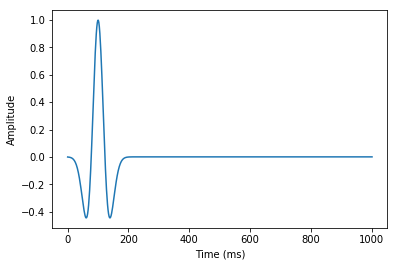

In [3]:
from examples.seismic import TimeAxis

t0 = 0.  # Simulation starts a t=0
tn = 1000.  # Simulation last 1 second (1000 ms)
dt = model.critical_dt  # Time step from model grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

from examples.seismic import RickerSource

f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range)

# Position source centrally in all dimensions, then set depth
src.coordinates.data[0, :] = np.array(model.domain_size) * .5
src.coordinates.data[0, -1] = 20.  # Depth is 20m

# We can plot the time signature to see the wavelet
src.show()

Similarly to our source object, we can now define our receiver geometry as a symbol of type `Receiver`.

In this example we will position receivers at the same depth as the source, every $10m$ along the x axis. The `rec.data` property will be initialized, but left empty, as we will compute the receiver readings during the simulation.

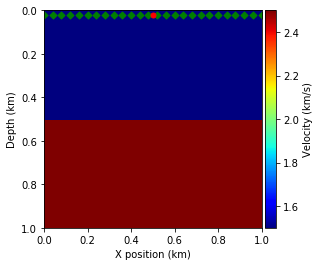

In [6]:
from examples.seismic import Receiver

# Create symbol for 101 receivers
rec = Receiver(name='rec', grid=model.grid, npoint=101, time_range=time_range)

# Prescribe even spacing for receivers along the x-axis
rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=101)
rec.coordinates.data[:, 1] = 20.  # Depth is 20m

# We can now show the source and receivers within our domain:
# Red dot: Source location
# Green dots: Receiver locations (every 4th point)
plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4, :])

## Build a wave equation solver

The acoustic wave equation for the square slowness $m$ defined as $m=\frac{1}{c^2}$, where $c$ is the speed of sound in the given physical media, and a source $q$ is given by:

\begin{cases} 
&m \frac{d^2 u(x,t)}{dt^2} - \nabla^2 u(x,t) + \eta \frac{d u(x,t)}{dt} = q \ \text{in } \Omega \\
& u(.,0) = 0 \\
&\frac{d u(x,t)}{dt}|_{t=0} = 0
\end{cases}

with the zero initial conditions to guarantee unicity of the solution, and where $\eta$ is a damping mask equal to $0$ inside the physical domain and increasing inside the sponge layer

We define the discrete Laplacian as the sum of the second order spatial derivatives in the three dimensions with a central difference discretization.

Here is Laplace's equation in 2D:
\begin{equation}
{\nabla ^2}u = \frac{{{\partial ^2}u}}{{\partial {x^2}}} + \frac{{{\partial ^2}u}}{{\partial {y^2}}} = 0
\end{equation}

The discretized equation is:
\begin{equation}
\frac{p^n_{i+1,j} - 2p^n_{i,j} + p^n_{i-1,j}}{\Delta x^2} + 
\frac{p^n_{i,j+1} - 2p^n_{i,j} + p^n_{i,j-1}}{\Delta y^2}
\end{equation}

solving for $p^n_{i,k}$:
\begin{equation}
p^n_{i,j} = \frac{\Delta y^2(p^n_{i+1,j}+p^n_{i-1,j}) + \Delta x^2(p^n_{i,j+1} + p^n_{p,j-1})}{2(\Delta x^2 + \Delta y^2)}
\end{equation}

It is also known as the **five-point difference operator**, alluding to its stencil.

We can fully discretize the wave-equation with the combination of time and space discretizations and obtain a second order in time and $k^{th}$ order in space discrete stencil to update one grid point at position $\mathbf{x}, \mathbf{y},\mathbf{z}$ at time $\mathbf{t}$, i.e.

In [7]:
from devito import TimeFunction

# Define the wavefield with the size of the model and the time dimension
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2)

from sympy import init_printing; init_printing(use_latex=True)
u

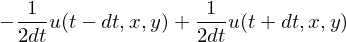

In [8]:
u.dt

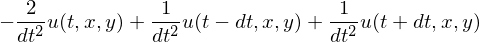

In [9]:
u.dt2

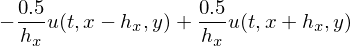

In [10]:
u.dx

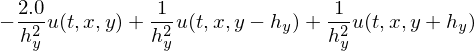

In [11]:
u.dy2

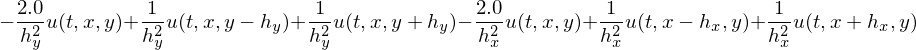

In [12]:
u.laplace

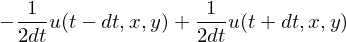

In [19]:
u2 = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=12)
u2.dt

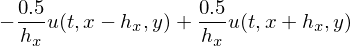

In [20]:
u.dx

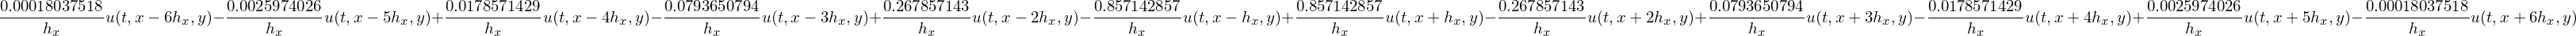

In [21]:
u2.dx

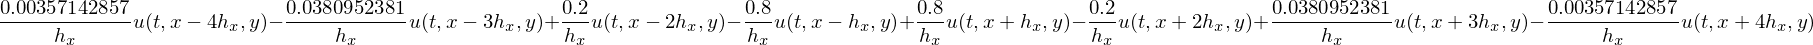

In [22]:
u3 = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=8)
u3.dx

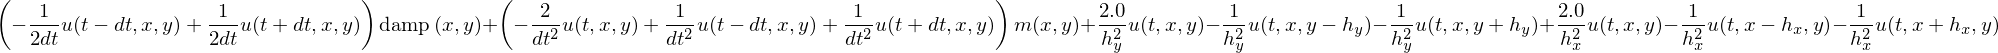

In [23]:
# We can now write the PDE
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
pde

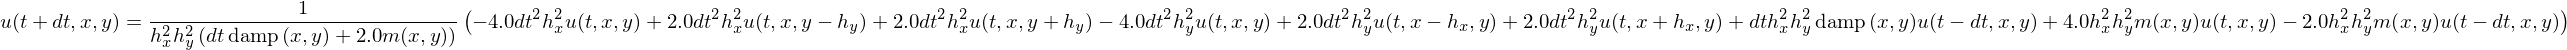

In [24]:
# This discrete PDE can be solved in a time-marching way updating 
# u(t+dt) from the previous time step
# Devito as a shortcut for u(t+dt) which is u.forward. We can then 
# rewrite the PDE as a time marching updating equation known as 
# a stencil using sympy functions
from sympy import Eq, solve


stencil = Eq(u.forward, solve(pde, u.forward)[0])
stencil

## Source injection and receiver interpolation

Operator `Kernel` run in 0.01 s
/home/lucas/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


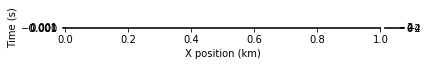

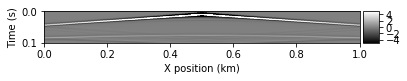

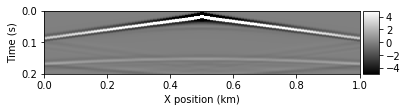

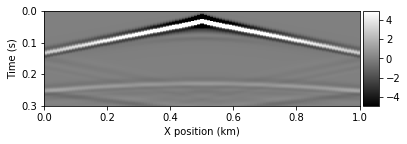

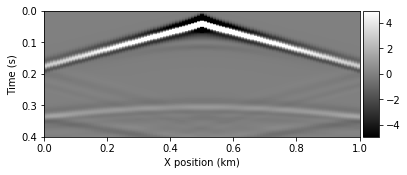

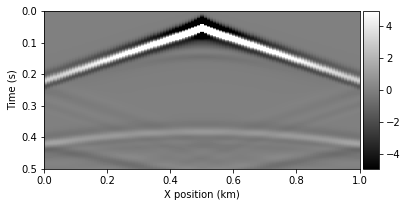

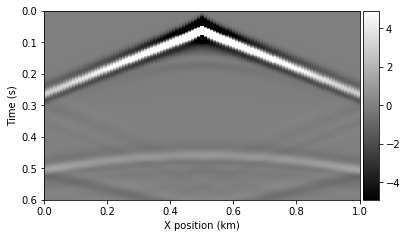

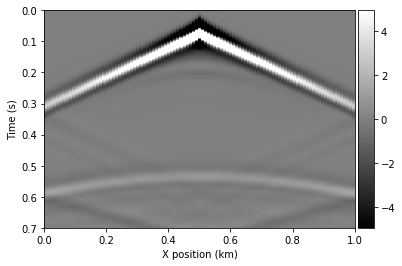

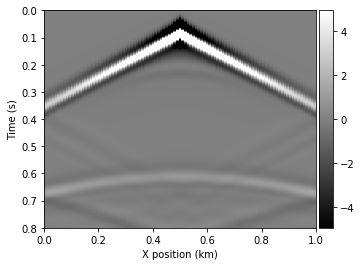

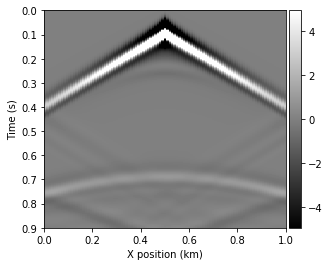

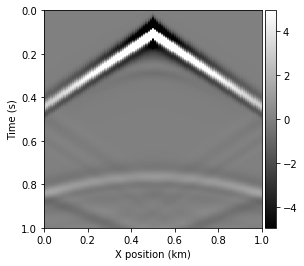

In [25]:
# Finally we define the source injection and receiver read function to generate the corresponding code
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m, offset=model.nbpml)

# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=u.forward, offset=model.nbpml)

from devito import Operator
op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)
op(time=time_range.num-1, dt=model.critical_dt)

from examples.seismic import plot_shotrecord
tl = list(np.linspace(0, 1000, 11))
for ti in tl:
    plot_shotrecord(rec.data, model, t0, ti)